## EN2550 Assignment 1 on Fitting and Alignment

190574U </br> Induwara Senadheera

In [2]:
import numpy as np
import cv2 as cv
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import random

In [3]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )





In [4]:
def RANSAC_line(Data_set,s,t,e,p):
    # s = No of points
    # t = Distance for the point from the drawn line to become inlinear
    # e = Outliar ratio
    # p = Success probability
    No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))*100

    max_inlinear_count=0
    best_fit_line_coefficient=[]

    for sample in range(0,No_of_iterations+1):
        point1,point2=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        #Ya + Xb + C = 0
        #Y(y1-y2)+X(x2-x1)+(x1*y2-y1*x2)=0
        a = Data_set[point1][1]-Data_set[point2][1]
        b = Data_set[point2][0]-Data_set[point1][0]
        c = Data_set[point1][0]*Data_set[point2][1] - Data_set[point1][1]*Data_set[point2][0]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs((a*Data_set[i][0] + b*Data_set[i][1]+c)/(np.sqrt(a**2+b**2)))
            if distance<t:
                inlinear_count+=1
        if inlinear_count > max_inlinear_count:
            max_inlinear_count = inlinear_count
            best_fit_line_coefficient = [a,b,c]
    
    plt.figure(figsize=(15,15))
    for data_point in Data_set:
        plt.scatter(data_point[0],data_point[1])
    x_values=np.arange(-15,15+1)
    y_values=-1*(x_values*best_fit_line_coefficient[0]+best_fit_line_coefficient[2])/best_fit_line_coefficient[1]

    plt.plot(x_values,y_values,color="red")
    plt.show()

    print("Number of Samples =",No_of_iterations)
    print("Inlinear Count =",max_inlinear_count)
    

<ipython-input-4-6ec5d73ccbc9>:21: RuntimeWarning: invalid value encountered in double_scalars
  distance=abs((a*Data_set[i][0] + b*Data_set[i][1]+c)/(np.sqrt(a**2+b**2)))


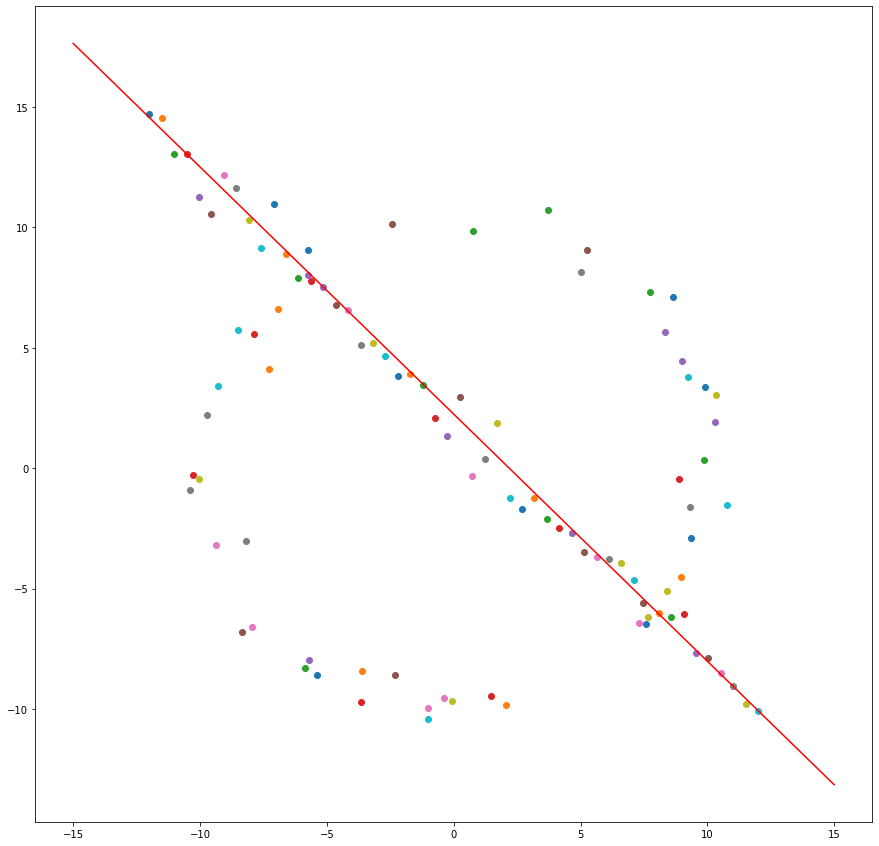

Number of Samples = 600
Inlinear Count = 54


In [5]:
RANSAC_line(X,2,1,0.3,0.99)

In [6]:


def RANSAC_circle(Data_set,No_of_iterations,t):
    max_inlinear_count=0
    best_fit_circle_coefficient=[]
    best_sample_points=[]
    
    for sample in range(0,No_of_iterations+1):
        point1,point2,point3=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        x1,x2,x3=Data_set[point1][0],Data_set[point2][0],Data_set[point3][0]
        y1,y2,y3=Data_set[point1][1],Data_set[point2][1],Data_set[point3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0):
            continue
        K=np.array([[x1**2 + y1**2] , [x2**2 + y2**2] , [x3**2+y3**2]])*(-1)
        answer=np.linalg.inv(P)@ K
        g,f,c=answer[0][0],answer[1][0],answer[2][0]
        radius=np.sqrt(g**2+f**2-c)
        if radius>20:
            continue
        center=[-g,-f]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs(np.sqrt((Data_set[i][0]-center[0])**2 + (Data_set[i][1]-center[1])**2) - radius)
            if distance < t:
                inlinear_count+=1
        if inlinear_count>max_inlinear_count:
            max_inlinear_count=inlinear_count
            best_fit_circle_coefficient=[g,f,c]
            best_sample_points=np.array([Data_set[point1],Data_set[point2],Data_set[point3]])
    return(best_fit_circle_coefficient,best_sample_points,max_inlinear_count)


In [7]:
s=3
t=1
e=0.5
p=0.99
No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

ransac_circle_coeff,ransac_sample,ransac_inlinear_count=RANSAC_circle(X,No_of_iterations,t)

F,G,C=ransac_circle_coeff[0],ransac_circle_coeff[1],ransac_circle_coeff[2]
R=np.sqrt(G**2+F**2-C)

#Finding Inlenear and Outlinear of the RANSAC Estimated Circle
In,Out=[],[]
for point in X:
    d=abs(np.sqrt((point[0]+G)**2+(point[1]+F)**2)-R)
    if d<t:
        In.append(point)
    else:Out.append(point)

Inlin = np.array(In).T
Outlin = np.array(Out).T
Samp = ransac_sample.T

print("Number of Itarations =",No_of_iterations)
print("RANSAC Estimated circle Inlinear Count =",ransac_inlinear_count)   

Number of Itarations = 34
RANSAC Estimated circle Inlinear Count = 48


In [8]:
best_circle_coeff,best_sample,best_inlinear_count=RANSAC_circle(X,10000,t)
best_F,best_G,best_C=best_circle_coeff[0],best_circle_coeff[1],best_circle_coeff[2]
best_R=np.sqrt(best_G**2+best_F**2-best_C)

bestt_sample=best_sample.T
print("best fitting circle Inlinear Count =",best_inlinear_count)

best fitting circle Inlinear Count = 54


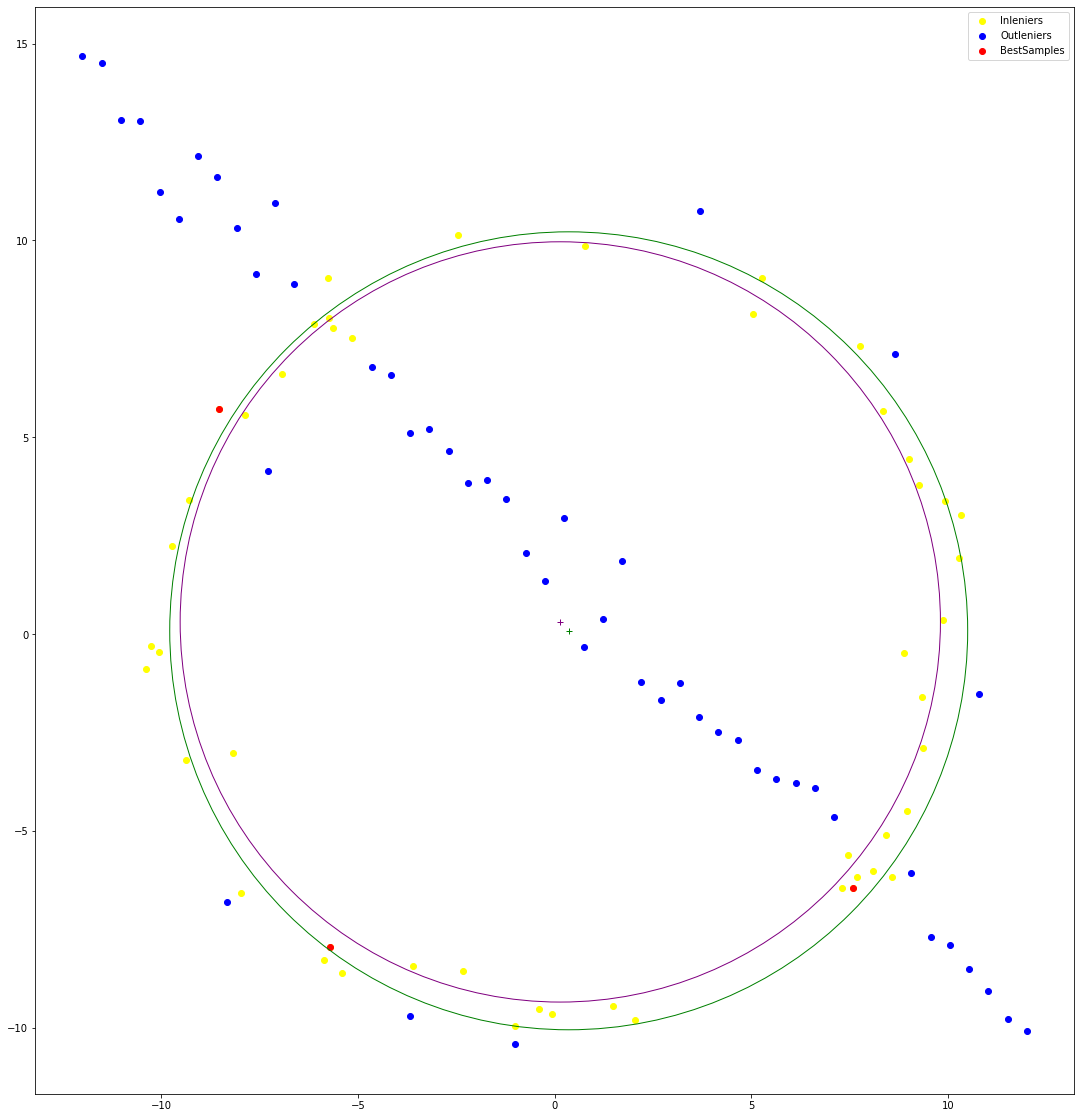

In [9]:
#plotting
figure, axes = plt.subplots( 1, figsize=(20,20) )

ransac_circle = plt.Circle((-G,-F), R, fill=False, color="purple" ,label="RANSAC")
best_fitting_circle = plt.Circle((-best_G,-best_F), best_R, fill=False, color="green" ,label="Best Fitting")

axes.scatter(Inlin[0],Inlin[1], color="yellow" , label="Inleniers")
axes.scatter(Outlin[0],Outlin[1], color="blue" , label="Outleniers")
axes.scatter(bestt_sample[0] ,bestt_sample[1], color="red" , label="BestSamples")
axes.plot(-G,-F,"+",color="purple")
axes.plot(-best_G,-best_F,"+",color="green")
axes.set_aspect( 1 )
axes.add_artist( ransac_circle )
axes.add_artist( best_fitting_circle )
plt.legend(loc ="upper right")
plt.show()

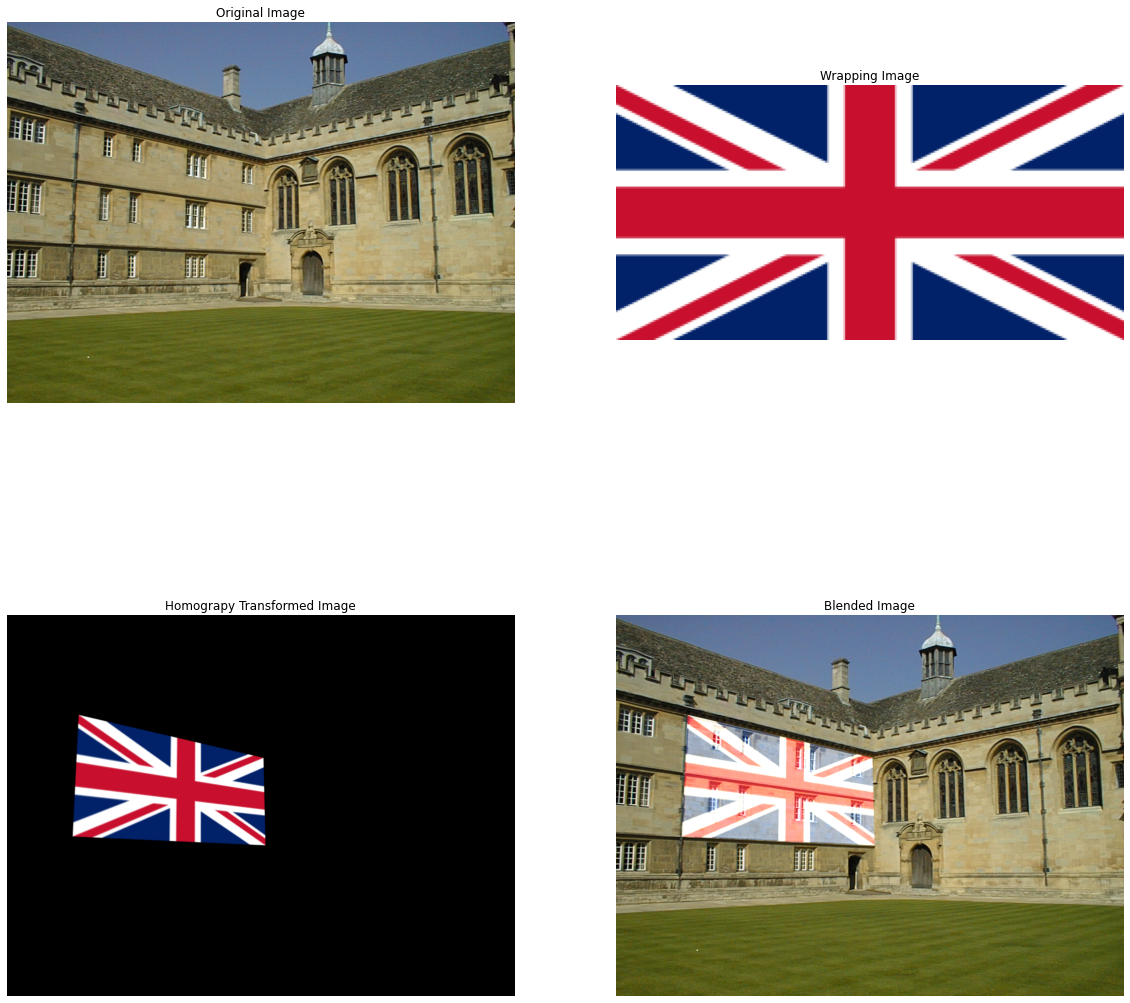

In [10]:
import numpy as np
import cv2 as cv
import matplotlib . pyplot as plt


def MouseHandling(event,x,y,f,pram):
    global im_temp,pts_src
    if event== cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp ,(x,y),3,(0,255,255),5,cv.LINE_AA)
        cv.imshow("Image",im_temp)
        if len(pts_src)<4:
            pts_src = np.append(pts_src,[(x,y)],axis=0)

architecture_img = cv.imread(r'./Images/Wadham College.jpg')
flag = cv.imread(r'./Images/Flag_of_the_United_Kingdom.svg.png')

height , width = architecture_img.shape[0] , architecture_img.shape[1]
f_width,f_height = flag.shape[1] , flag.shape[0]

pts_dst = np.array([[0,0] , [f_width-1,0] , [f_width-1,f_height-1] , [0,f_height-1] ])

cv.namedWindow("Image",1)

ppp = cv.cvtColor(architecture_img, cv.COLOR_BGR2RGB)
im_temp = cv.cvtColor(ppp, cv.COLOR_RGB2BGR)
pts_src = np.empty((0,2))

cv.setMouseCallback("Image", MouseHandling)

cv.imshow("Image",im_temp)
cv.waitKey(0)

Homograpy_Matrix , status = cv.findHomography(pts_src, pts_dst)

transformed_flag = cv.warpPerspective(flag, np.linalg.inv(Homograpy_Matrix), (width, height))

blend_image = cv.addWeighted(architecture_img, 1, transformed_flag, 0.8, 0)

cv.imshow("Image",blend_image)
cv.waitKey(0)

figure, axes = plt.subplots( 2,2, figsize=(20,20) )
axes[0,0].imshow(cv.cvtColor(architecture_img,cv.COLOR_BGR2RGB))
axes[0,0].set_title("Original Image")
axes[0,0].axis("off")
axes[0,1].imshow(cv.cvtColor(flag,cv.COLOR_BGR2RGB))
axes[0,1].set_title("Wrapping Image")
axes[0,1].axis("off")
axes[1,0].imshow(cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB))
axes[1,0].set_title("Homograpy Transformed Image")
axes[1,0].axis("off")
axes[1,1].imshow(cv.cvtColor(blend_image,cv.COLOR_BGR2RGB))
axes[1,1].set_title("Blended Image")
axes[1,1].axis("off")

cv.destroyAllWindows()

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def MouseHandling(event,x,y,f,pram):
    global im_temp,pts_src
    if event== cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp ,(x,y),3,(0,255,255),5,cv.LINE_AA)
        cv.imshow("Image",im_temp)
        if len(pts_src)<4:
            pts_src = np.append(pts_src,[(x,y)],axis=0)

def IMG_WRAP(original,wrapping_img):
    global im_temp,pts_src
    height,width=original.shape[0],original.shape[1]
    wrp_height,wrp_width=wrapping_img.shape[0],wrapping_img.shape[1]

    pts_dst=np.array([[0,0],[wrp_width-1,0],[wrp_width-1,wrp_height-1],[0,wrp_height-1]])
    cv.namedWindow("Image",1)

    org_temp=cv.cvtColor(original,cv.COLOR_BGR2RGB)
    im_temp=cv.cvtColor(org_temp,cv.COLOR_RGB2BGR)

    pts_src=np.empty((0,2))

    cv.setMouseCallback("Image",MouseHandling)

    cv.imshow("Image",im_temp)
    cv.waitKey(0)

    Homograpy_Matrix,status=cv.findHomography(pts_src,pts_dst)
    transformed_wrapper=cv.warpPerspective(wrapping_img,np.linalg.inv(Homograpy_Matrix),(width,height))
    blend_image=cv.addWeighted(original,1,transformed_wrapper,0.8,0)

    cv.imshow("Image",blend_image)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return(transformed_wrapper,blend_image)
    

(-0.5, 599.5, 599.5, -0.5)

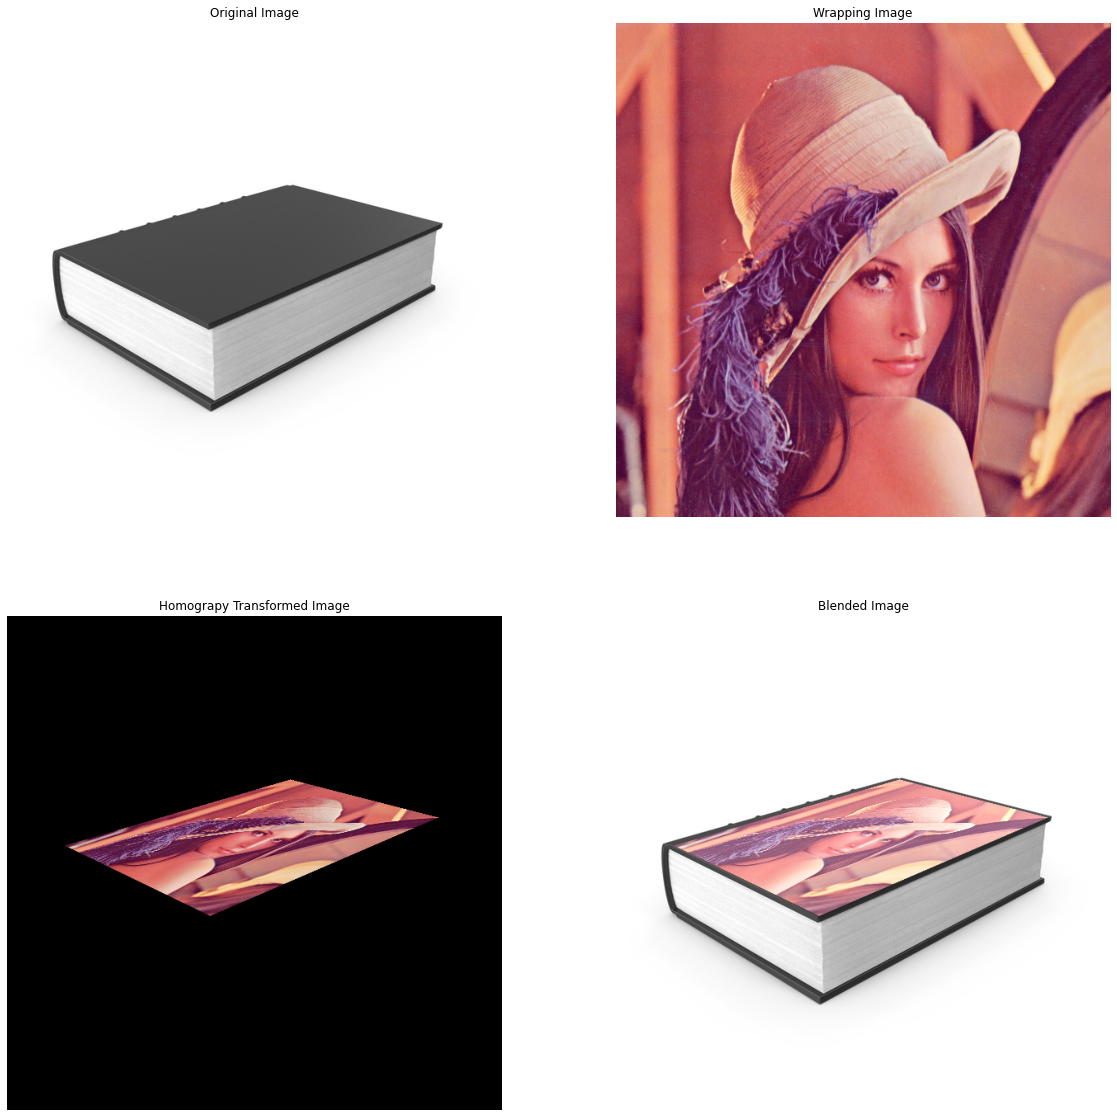

In [4]:
book = cv.imread(r'./Images/book_cover.jpg')
assert book is not None
lenna = cv.imread(r'./Images/Lenna.png')
assert lenna is not None

transformed_lenna,blend_cover=IMG_WRAP(book,lenna)

figure, axes = plt.subplots( 2,2, figsize=(20,20) )
axes[0,0].imshow(cv.cvtColor(book,cv.COLOR_BGR2RGB))
axes[0,0].set_title("Original Image")
axes[0,0].axis("off")
axes[0,1].imshow(cv.cvtColor(lenna,cv.COLOR_BGR2RGB))
axes[0,1].set_title("Wrapping Image")
axes[0,1].axis("off")
axes[1,0].imshow(cv.cvtColor(transformed_lenna,cv.COLOR_BGR2RGB))
axes[1,0].set_title("Homograpy Transformed Image")
axes[1,0].axis("off")
axes[1,1].imshow(cv.cvtColor(blend_cover,cv.COLOR_BGR2RGB))
axes[1,1].set_title("Blended Image")
axes[1,1].axis("off")



(-0.5, 625.5, 408.5, -0.5)

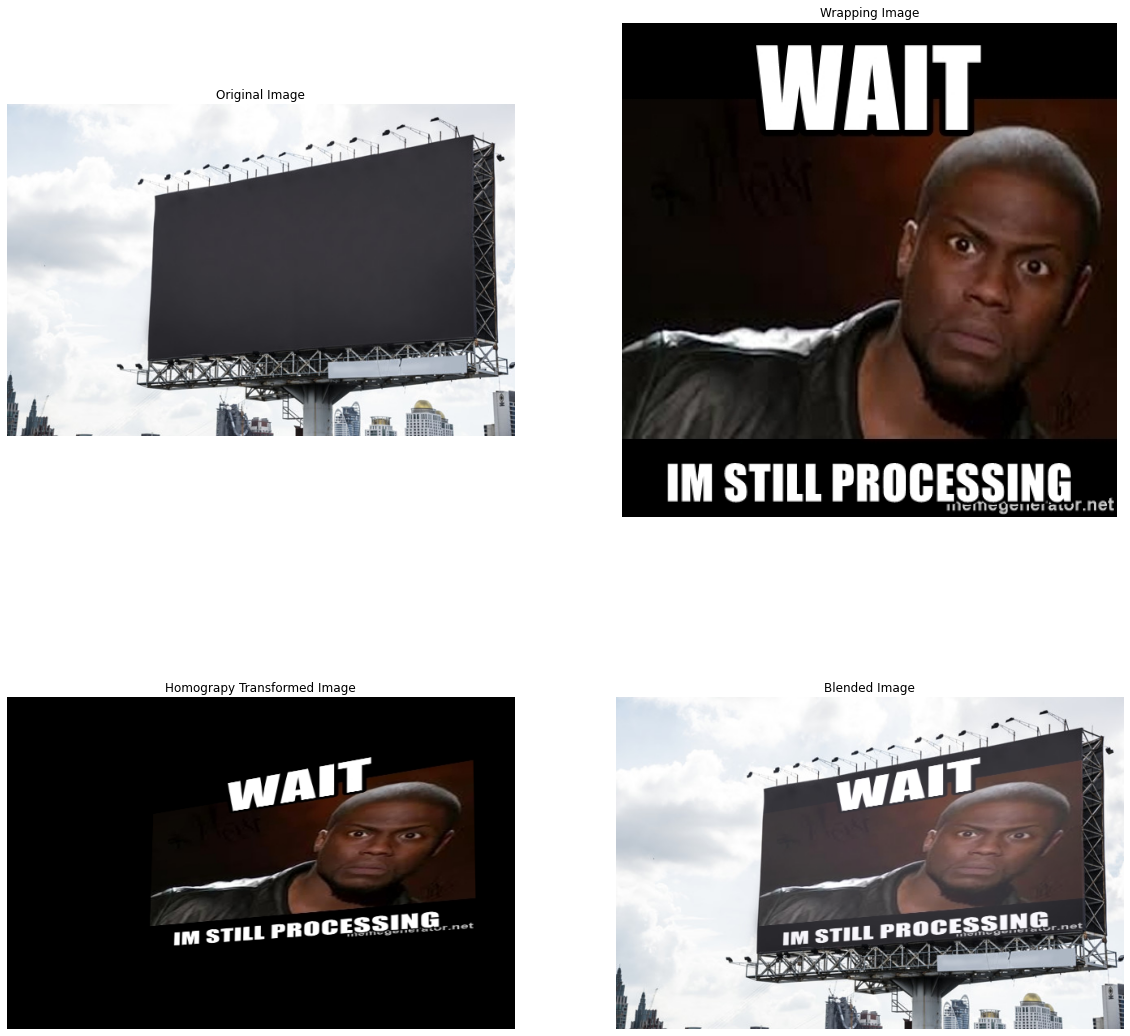

In [7]:
billboard = cv.imread(r'./Images/billboard.jpg')
assert billboard is not None
meme = cv.imread(r'./Images/still_processing.jpg')
assert meme is not None

transformed_lenna,blend_cover=IMG_WRAP(billboard,meme)

figure, axes = plt.subplots( 2,2, figsize=(20,20) )
axes[0,0].imshow(cv.cvtColor(billboard,cv.COLOR_BGR2RGB))
axes[0,0].set_title("Original Image")
axes[0,0].axis("off")
axes[0,1].imshow(cv.cvtColor(meme,cv.COLOR_BGR2RGB))
axes[0,1].set_title("Wrapping Image")
axes[0,1].axis("off")
axes[1,0].imshow(cv.cvtColor(transformed_lenna,cv.COLOR_BGR2RGB))
axes[1,0].set_title("Homograpy Transformed Image")
axes[1,0].axis("off")
axes[1,1].imshow(cv.cvtColor(blend_cover,cv.COLOR_BGR2RGB))
axes[1,1].set_title("Blended Image")
axes[1,1].axis("off")

In [12]:
print(pts_src)
print(Homograpy_Matrix)

[[145. 202.]
 [516. 288.]
 [520. 463.]
 [133. 445.]]
[[ 4.48197529e-01  2.21332113e-02 -6.94595503e+01]
 [-1.15755194e-01  4.99362523e-01 -8.40867265e+01]
 [-7.35285640e-04  1.44277892e-04  1.00000000e+00]]
